In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

# Collection
This is where all the code is collected after testing in the individual files to make graphs for my paper 

### Preliminary global variables
For continuity, these variables are never changed so that all models come from a place of consistency 

In [2]:
try:
    with open('glob_var/global_variables.json') as f:
        GV = json.load(f)
except FileNotFoundError:
    print("Global variables json not found!")

## Wednesday 18th June - Steady Sate Equation Solve

We take the initial differential equation for the thin films and integrate it to get 
$$
\frac{\partial h}{\partial t} = h^3\frac{\partial^3h}{\partial x^3} + h = \tilde{Q},
$$
where $\tilde{Q}$ is the dimensionless flux, to be constant at $q(x=0)$ and experimented with. We set $\frac{\partial h}{\partial t} = 0,$ then transform the ODE into a system of first order ODEs, where
$$
\vec{y} = \begin{bmatrix}
            y_1 = h \\ y_2 = \frac{dh}{dx} \\ y_3 = \frac{d^2h}{dx^2}
            \end{bmatrix}
$$

meaning 

$$
\dot{\vec{y}} = \begin{bmatrix}
            \dot{y_1} = y_2 \\ \dot{y_2} = y_3 \\ \dot{y_3} = \frac{\tilde{Q}-y_1}{y_1^3}.
            \end{bmatrix}
$$
We also have the boundary conditions
$$
\begin{aligned}
y_1(x=0) = 1 \\
y_2(x=L) = 0.5 \\
y_1(x=L) = \tilde{Q},
\end{aligned}
$$

We then implement this using scipy's ```solve_bvp``` function.

##### We define the system of ODEs and the BCs in ```../newtonian_thin_film_solve/individual_files/stead_state_central_differences.py```

In [3]:
from newtonian_thin_film_solve.individual_files.steady_state_central_differences import plot_solution
from newtonian_thin_film_solve.individual_files.steady_state_central_differences import solver as bdf_solver

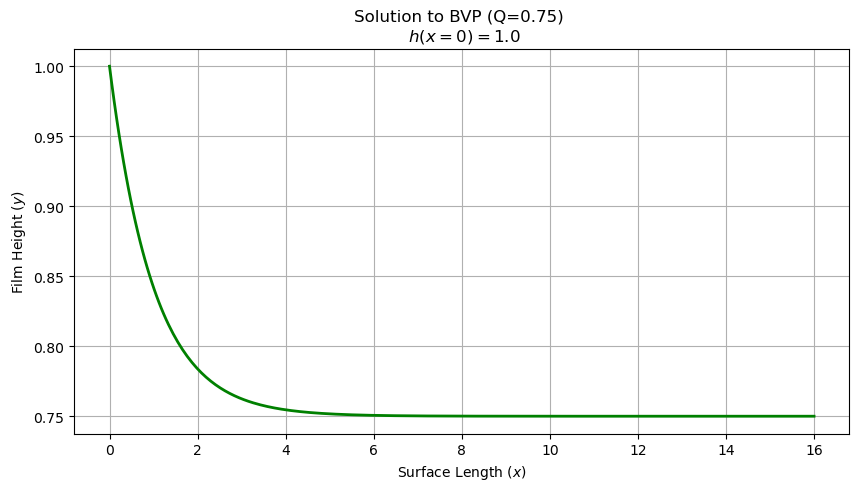

In [4]:
solution = bdf_solver(q=GV['Q'], L=GV['L'], linear=True)
plot_solution(solution=solution, q=GV['Q'])

In [5]:
linear_solution_Q = []      # Store linear solutions varying Q
linear_solution_L = []      # Store linear solutions varying L
non_linear_solution_Q = []  # Store non-linear solutions varying Q
non_linear_solution_L = []  # Store non-linear solutions varying L

for i in range(len(GV['Q-list'])):
    linear_solution_Q.append(bdf_solver(q=GV['Q-list'][i], L=GV['L'], linear=True).y[0])
    non_linear_solution_Q.append(bdf_solver(q=GV['Q-list'][i], L=GV['L'], linear=False).y[0])
for i in range(len(GV['L-list'])):
    linear_solution_L.append(bdf_solver(q=GV['Q'], L=GV['L-list'][i], linear=True).y[0])
    non_linear_solution_L.append(bdf_solver(q=GV['Q'], L=GV['L-list'][i], linear=False).y[0])

Plot a fancy graph for the paper, I used the [inset_axes](https://python-graph-gallery.com/how-to-add-plot-inside-plot/) feature to create the small part in the length graph to zoom in to confirm the lines are all there.

(0.8, 0.81)

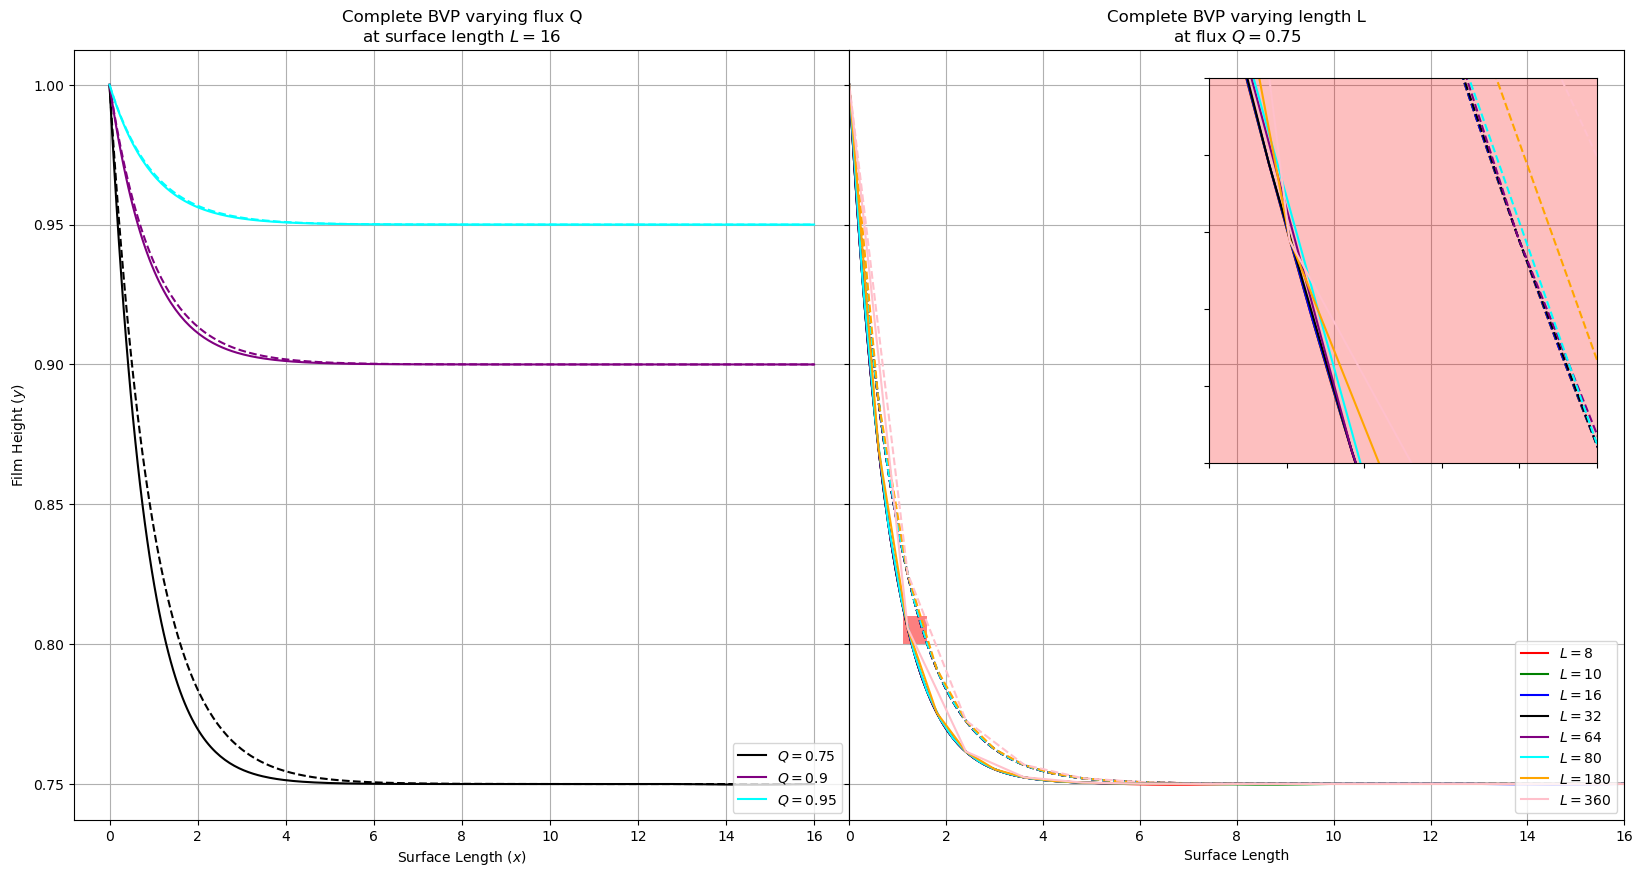

In [6]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
fig.subplots_adjust(wspace=0.0)

[ax[0].plot(GV['x'], linear_solution_Q[i], color=GV['colors'][i], linestyle='--') for i in range(3, len(GV['Q-list']))]
[ax[0].plot(GV['x'], non_linear_solution_Q[i], color=GV['colors'][i], label=f"$Q={GV['Q-list'][i]}$", linestyle='-') for i in range(3, len(GV['Q-list']))]
ax[0].legend(loc='lower right')
ax[0].grid(True)
ax[0].set_title(f"Complete BVP varying flux Q\nat surface length $L={GV['L']}$")
ax[0].set_xlabel("Surface Length $(x)$")
ax[0].set_ylabel("Film Height $(y)$")

slice_x = (1.1, 1.6)
slice_y = (0.8, 0.81)

[ax[1].plot(np.linspace(0, GV['L-list'][i], GV['N']), linear_solution_L[i], color=GV['colors'][i], linestyle='--') for i in range(len(GV['L-list']))]
[ax[1].plot(np.linspace(0, GV['L-list'][i], len(non_linear_solution_L[i])), non_linear_solution_L[i], color=GV['colors'][i], label=f"$L={GV['L-list'][i]}$", linestyle='-') for i in range(len(GV['L-list']))]
ax[1].legend(loc='lower right')
ax[1].set_xlim(0, GV['L'])
ax[1].grid(True)
ax[1].set_yticklabels([])
ax[1].set_title(f"Complete BVP varying length L\nat flux $Q={GV['Q']}$")
ax[1].set_xlabel("Surface Length")
ax[1].add_patch(plt.Rectangle(xy=(slice_x[0], slice_y[0]), width=(slice_x[1]-slice_x[0]), height=(slice_y[1] - slice_y[0]), ls='--', fc='#fa000080'))

inset_ax = inset_axes(ax[1], width='50%', height='50%', loc='upper right', borderpad=2, axes_kwargs={'facecolor': '#fa000040'})
[inset_ax.plot(np.linspace(0, GV['L-list'][i], GV['N']), linear_solution_L[i], color=GV['colors'][i], linestyle='--') for i in range(len(GV['L-list']))]
[inset_ax.plot(np.linspace(0, GV['L-list'][i], len(non_linear_solution_L[i])), non_linear_solution_L[i], color=GV['colors'][i], linestyle='-') for i in range(len(GV['L-list']))]
inset_ax.set_xticklabels([])
inset_ax.set_yticklabels([])
inset_ax.set_xlim(slice_x[0], slice_x[1])
inset_ax.set_ylim(slice_y[0], slice_y[1])


## Monday 8th July - Startup-Flow Solve
The startup flow includes the time derivative, we see the film develop over time to hopefully produce the same thing as the steady state flow. We used the finite volume method to solve this PDE to ensure conservation of the mass of our 'quantities'

Here, for this application of the FVM method, as the boundary conditions are the same, the overhead equation for solving this PDE should be the same across models: $$\frac{\partial h}{\partial t} = -\frac{q_{i+\frac{1}{2}} - q_{i-\frac{1}{2}}}{\Delta x}$$and the only thing that is changing is the details inside the above equation, meaning we can define the RHS and apply the boundary conditions $$\begin{aligned} h[0] = h_0 \\ dhdt[1] = -\frac{q_{i+\frac{1}{2}} - Q}{dx} \\ dhdt[N-2] = -\frac{h[N-2] - q_{i-\frac{1}{2}}}{dx} \\ dhdt[N-1] = dhdt[N-2] \end{aligned} $$ in one equation that we can use for the rest of the investigation for startup flow across rheologies, located in ```../glob_var/FVM/FVM_RHS.py```

In [3]:
from glob_var.FVM.FVM_RHS import FVM_RHS

From here, the ```make_step``` function can be imported from ```../newtonian_thin_film_solve/individual_files/startup_flow_FVM.py```, controlling the rheology of the fluid, in this case, our fluid is Newtonian.

In [8]:
from newtonian_thin_film_solve.individual_files.startup_flow_FVM import make_step as newt_make_step

Time for a test run...

In [9]:
try:
    args = [newt_make_step, GV['dx'], 3, GV['Q'], None, None]
    h_initial = np.ones(GV['N']) * GV['h0']
    min_t = GV['t-span'][f"{GV['L']}"]
    t_span = (0, min_t)
    
    sol = solve_ivp(fun=FVM_RHS, args=(args,), y0=h_initial, t_span=t_span, method='BDF', rtol=1e-6, atol=1e-8)

    print(sol.status)
    print(sol.success)
    print(sol.message)

except ValueError:
    print("Value Error")

0
True
The solver successfully reached the end of the integration interval.


Text(0, 0.5, 'Film Height $(y)$')

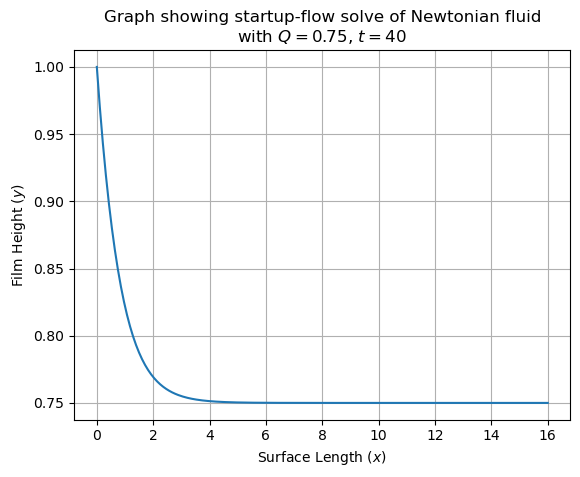

In [10]:
plt.plot(GV['x'], sol.y[:, -1])
plt.title(f"Graph showing startup-flow solve of Newtonian fluid\nwith $Q={GV['Q']}$, $t={t_span[1]}$")
plt.grid(True)
plt.xlabel('Surface Length $(x)$')
plt.ylabel('Film Height $(y)$')

In [11]:
linear_solution_Q = []      # Store linear solutions varying Q
non_linear_solution_Q = []  # Store non-linear solutions varying Q

for i in range(len(GV['Q-list'])):
    h_initial = np.ones(GV['N']) * GV['h0']
    
    args = [newt_make_step, GV['dx'], 0, GV['Q-list'][i], None, None]
    linear_solution_Q.append(solve_ivp(fun=FVM_RHS, args=(args,), y0=h_initial, t_span=t_span, method='BDF', rtol=1e-6, atol=1e-8).y[:, -1])
    
    args = [newt_make_step, GV['dx'], 3, GV['Q-list'][i], None, None]
    non_linear_solution_Q.append(solve_ivp(fun=FVM_RHS, args=(args,), y0=h_initial, t_span=t_span, method='BDF', rtol=1e-6, atol=1e-8).y[:, -1])

KeyboardInterrupt: 

Text(0, 0.5, 'Film Height $(y)$')

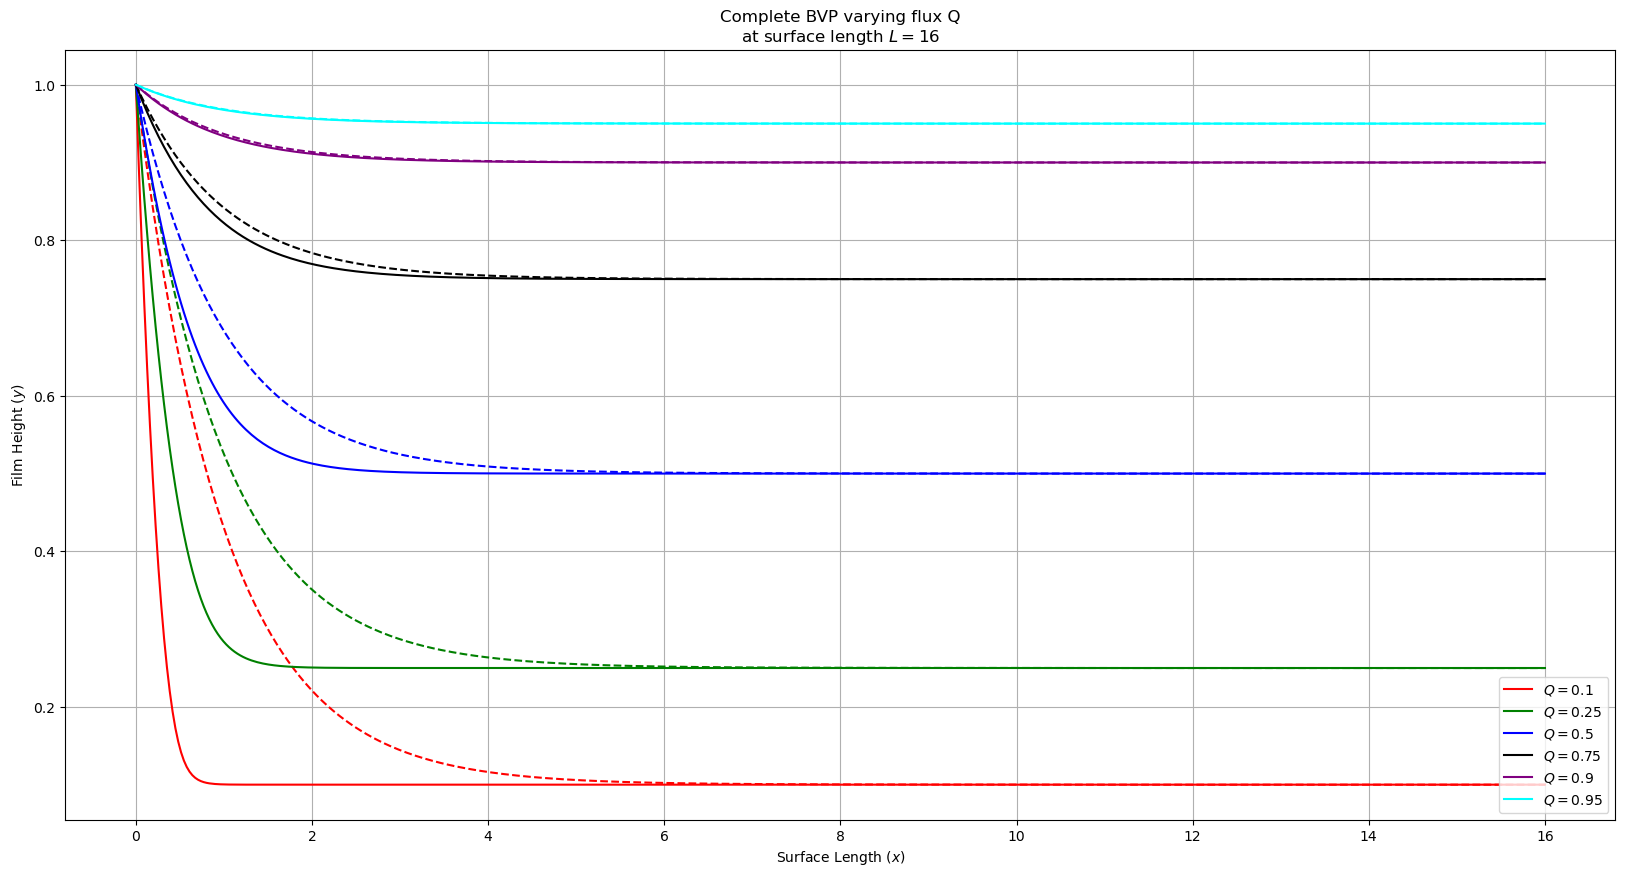

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
fig.subplots_adjust(wspace=0.0)

[ax.plot(GV['x'], linear_solution_Q[i], color=GV['colors'][i], linestyle='--') for i in range(len(GV['Q-list']))]
[ax.plot(GV['x'], non_linear_solution_Q[i], color=GV['colors'][i], label=f"$Q={GV['Q-list'][i]}$", linestyle='-') for i in range(len(GV['Q-list']))]
ax.legend(loc='lower right')
ax.grid(True)
ax.set_title(f"Complete BVP varying flux Q\nat surface length $L={GV['L']}$")
ax.set_xlabel("Surface Length $(x)$")
ax.set_ylabel("Film Height $(y)$")

## Animation
Let's try and generate an animation!

In [4]:
from glob_var.animation import Animation

In [13]:
args = [newt_make_step, GV['dx'], 3, GV['Q'], None, None]
h_initial = np.ones(GV['N']) * GV['h0']
min_t = GV['t-span'][f"{GV['L']}"]
t_span = (0, min_t)

sol = solve_ivp(fun=FVM_RHS, args=(args,), y0=h_initial, t_span=t_span, method='BDF', rtol=1e-6, atol=1e-8)

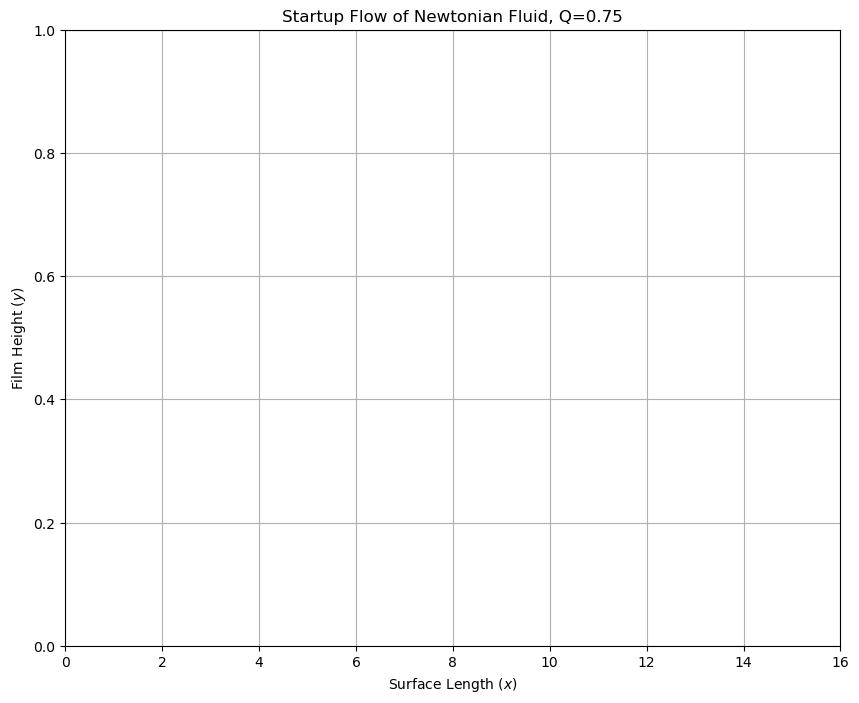

In [16]:
# Because the data we just generated is only a 2d array and our animation class takes 3D matrices, we need to add an extra dimension to sol.
data = sol.y
data = [data[None, :, :],]
num_frames = sol.y.shape[1]

# Now outline some figure details to add to the plot
fig_details = {
    'x-lim': (0, GV['L']),
    'y-lim': (0, GV['h0']),
    'legend': [False,],
    'grid': [True],
    'title': [f"Startup Flow of Newtonian Fluid, Q={GV['Q']}",],
    'x-label': ['Surface Length $(x)$'],
    'y-label': ['Film Height $(y)$'],
}

# Instantiate the Animation class
newt_animation = Animation(num_rows=1, num_cols=1,
                           fig_size=(10, 8), x=GV['x'],
                           data=data, min_timestep=num_frames,
                           fig_details=fig_details)

newt_animation.instantiate_animation()
newt_animation.save_animation('animation/newt_no_dp_q_075')

## Wednesday 16th July - Power Law Fluid

The numerics of non-Newtonian flow are very similar for the power law as Newtonian flow, it's the maths that's that's the hard part, which is explained in my thesis, linked in the READ_ME of this repo. The short version is that we replace the stress tensor $\tau$ with the power law: $\tau = \hat{\mu}|\dot{\gamma}|^{\frac{1}{n}}\dot{\gamma}$ and inject this into the equation for the pressure, take the derivative and go from there. 

We use the same finite volume method, only altering the function outlining the content of the RHS which now contains a lot of n's. We solve the equation 
$$
h_t = -\frac{\partial}{\partial x}\left(h^{\frac{2n+1}{n}}sgn(h_{xxx})\left|h_{xxx}\right|^{\frac{1}{n}}\right) + h_x
$$ 

We test this equation by setting n to 1 which we can do both analytically and numerically. The latter will be done in this jupyter notebook. <br> As stated, the only function that is altered for non-Newtonian startup flow is the function for making the step in space, we can import it from ```../non_newtonian_thin_film_solve/individual_files/power_law_startup.py```

In [17]:
from non_newtonian_thin_film_solve.individual_files.power_law_startup import make_step as PL_make_step

In [5]:
n = 1.1
h_initial = np.ones(GV['N']) * GV['h0']
min_t = GV['t-span'][f"{GV['L']}"]
t_span = (0, min_t)
args = [PL_make_step, GV['dx'], None, GV['Q'], None, n]

sol = solve_ivp(fun=FVM_RHS, y0=h_initial, t_span=t_span, args=(args,), method='BDF', rtol=1e-6, atol=1e-8)

print(sol.status)
print(sol.success)
print(sol.message)

0
True
The solver successfully reached the end of the integration interval.


Text(0, 0.5, 'Film Height $(y)$')

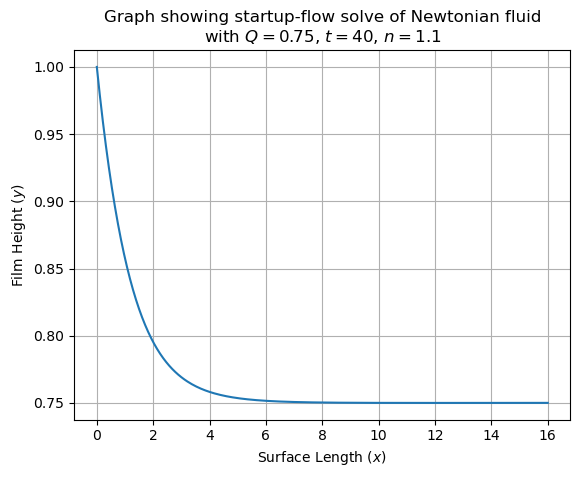

In [6]:
plt.plot(GV['x'], sol.y[:, -1])
plt.title(f"Graph showing startup-flow solve of Newtonian fluid\nwith $Q={GV['Q']}$, $t={t_span[1]}$, $n={n}$")
plt.grid(True)
plt.xlabel('Surface Length $(x)$')
plt.ylabel('Film Height $(y)$')

To make a fancier graph, we vary n for constant volume flux to observe the effect of n on the film's behaviour

In [30]:
power_law_solutions = []

for i in range(len(GV['n-list'])):
    print(f"Solving for n = {GV['n-list'][i]}", end='\r')
    args = [PL_make_step, GV['dx'], None, GV['Q'], None, GV['n-list'][i]]
    power_law_solutions.append(solve_ivp(fun=FVM_RHS, y0=h_initial, t_span=t_span, args=(args,), method='BDF', rtol=1e-6, atol=1e-8).y[:, -1])    

Text(0.5, 1.0, 'Graph showing film height for a power-law fluid\nwith varying n')

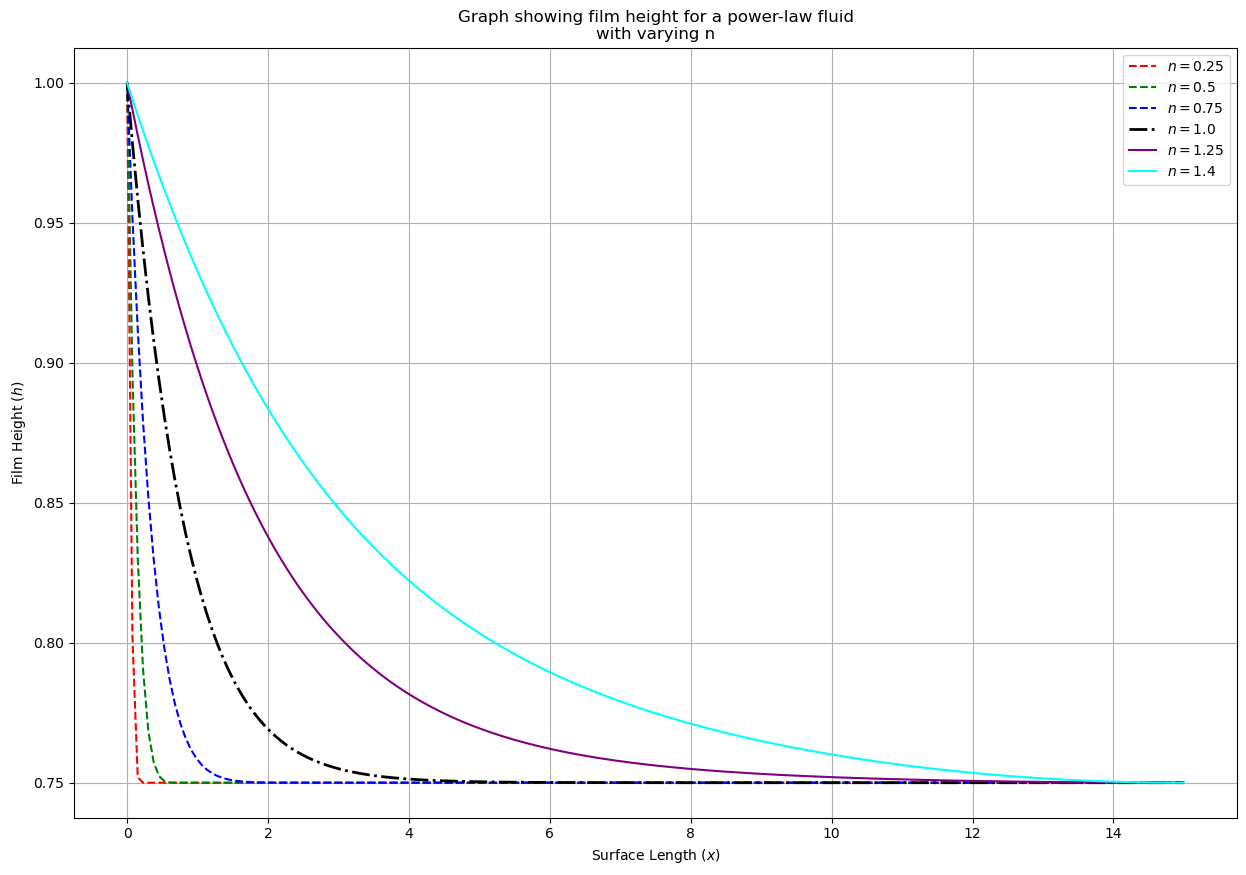

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

for i in range(len(GV['n-list'])):
    if GV['n-list'][i] < 1.0: ax.plot(GV['x'], power_law_solutions[i], label=f"$n = {GV['n-list'][i]}$", color=GV['colors'][i], linestyle='--')
    elif GV['n-list'][i] == 1.0: ax.plot(GV['x'], power_law_solutions[i], label=f"$n = {GV['n-list'][i]}$", color=GV['colors'][i], linestyle='-.', linewidth=2)
    else: ax.plot(GV['x'], power_law_solutions[i], label=f"$n = {GV['n-list'][i]}$", color=GV['colors'][i], linestyle='-')
    
ax.legend()
ax.grid(True)
ax.set_xlabel("Surface Length $(x)$")
ax.set_ylabel("Film Height $(h)$")
ax.set_title(f"Graph showing film height for a power-law fluid\nwith varying n")

## Thursday - July 17th Newtonian Startup-Flow with Disjoint pressure

When looking at a new term that applies to both Newtonian and non-Newtonian rheologies, it's best to go back to the simpler, Newtonian model first. Here, the ```make_step``` function is modified in ```../newtonian_thin_film_solve/individual_files/newtonian_DP.py``` to include a disjoint pressure term. 

In [5]:
from newtonian_thin_film_solve.individual_files.newtonian_DP import make_step as newt_DP_make_step

In [8]:
try:
    args = [newt_DP_make_step, GV['dx'], 3, GV['Q'], 0.13, None]
    h_initial = np.ones(GV['N']) * GV['h0']
    min_t = GV['t-span'][f"{GV['L']}"]
    t_span = (0, min_t)
    
    sol = solve_ivp(fun=FVM_RHS, args=(args,), y0=h_initial, t_span=t_span, method='BDF', rtol=1e-6, atol=1e-8)

    print(sol.status)
    print(sol.success)
    print(sol.message)

except ValueError:
    print("Value Error")

0
True
The solver successfully reached the end of the integration interval.


Text(0, 0.5, 'Film Height $(y)$')

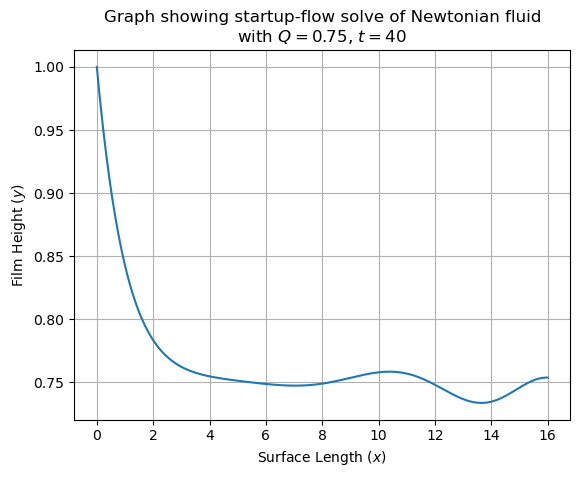

In [9]:
plt.plot(GV['x'], sol.y[:, -1])
plt.title(f"Graph showing startup-flow solve of Newtonian fluid\nwith $Q={GV['Q']}$, $t={t_span[1]}$")
plt.grid(True)
plt.xlabel('Surface Length $(x)$')
plt.ylabel('Film Height $(y)$')

### Testing with DP

In [109]:
A_values = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
h_initial = np.ones(GV['N']) * GV['h0']

newt_DP_sols = []
for i in range(len(A_values)):
    args = [newt_DP_make_step, GV['dx'], 3, GV['Q'], A_values[i], None]
    newt_DP_sols.append(solve_ivp(fun=FVM_RHS, args=(args,), y0=h_initial, t_span=t_span, method='BDF', rtol=1e-6, atol=1e-8).y[:, -1])

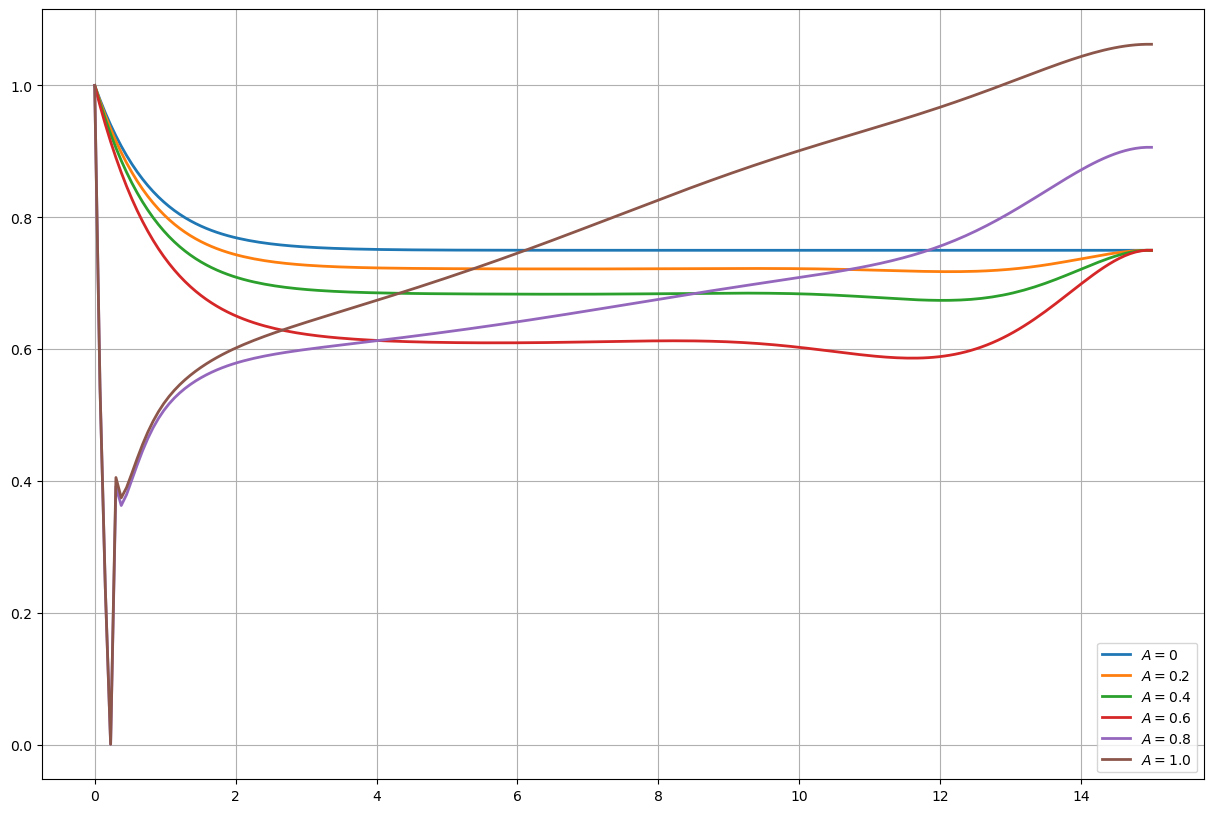

In [111]:
fig, ax = plt.subplots(figsize=(15,10))

[ax.plot(GV['x'], newt_DP_sols[i], label=f"$A={A_values[i]}$", linestyle='-', linewidth=2) for i in range(len(A_values))]
ax.legend()
ax.grid(True)

## Thursday 18th July - non-Newtonian Startup Flor for Power-law Fluid

Now we have successfully added the disjoint pressure term to the Newtonian fluid, let's add it to the more complicated one. Actually, there is no difference in implementation of the DP term for the Power Law fluid. We applied DP to the Newtonian model first because it is easier to interpret the outcome of a Newtonian fluid as it is more familiar, therefore knowing if DP is working would be easier to assess. We now import the new make step function from ```../non_newtonian_thin_film_solve/individual_files/power_law_dp.py```

In [10]:
from non_newtonian_thin_film_solve.individual_files.power_law_dp import make_step as PL_DP_make_step

In [11]:
n = 1.0
h_initial = np.ones(GV['N']) * GV['h0']
min_t = GV['t-span'][f"{GV['L']}"]
t_span = (0, min_t)
args = [PL_DP_make_step, GV['dx'], None, GV['Q'], 0.14, n]

sol = solve_ivp(fun=FVM_RHS, y0=h_initial, t_span=t_span, args=(args,), method='BDF', rtol=1e-6, atol=1e-8)

print(sol.status)
print(sol.success)
print(sol.message)

-1
False
Required step size is less than spacing between numbers.


Text(0, 0.5, 'Film Height $(y)$')

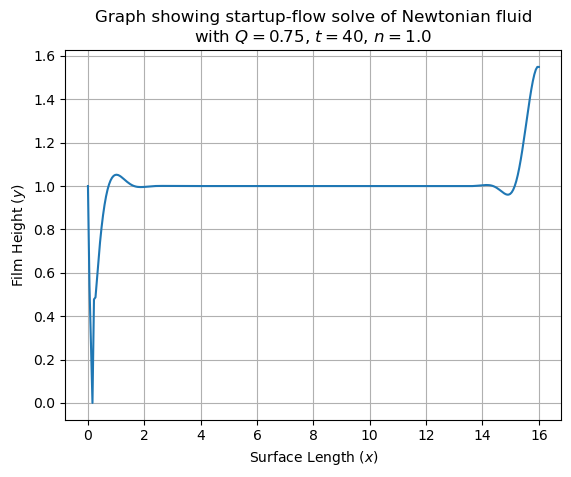

In [12]:
plt.plot(GV['x'], sol.y[:, -1])
plt.title(f"Graph showing startup-flow solve of Newtonian fluid\nwith $Q={GV['Q']}$, $t={t_span[1]}$, $n={n}$")
plt.grid(True)
plt.xlabel('Surface Length $(x)$')
plt.ylabel('Film Height $(y)$')

### Making an animation for this

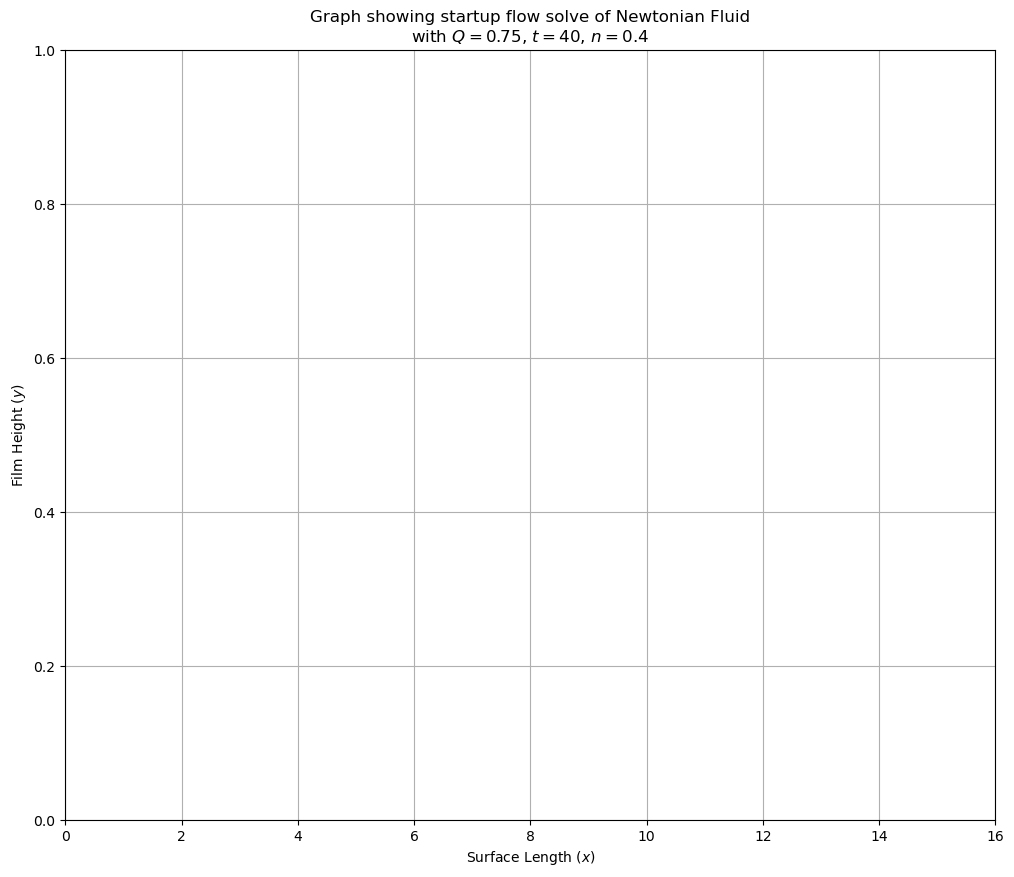

In [14]:
DP_anim = Animation(
    fig_size=(12, 10), x=GV['x'],
    data=[sol.y[None, :, :],], min_timestep=sol.y.shape[1],
    fig_details = {
        'x-lim': (0, GV['L']),
        'y-lim': (0, GV['h0']),
        'legend': [False,],
        'grid': [True,],
        'x-label': ["Surface Length $(x)$",],
        'y-label': ["Film Height $(y)$",],
        'title': [f"Graph showing startup flow solve of non-Newtonian Fluid\nwith $Q={GV['Q']}$, $t={t_span[1]}$, $n={n}$",],
    }
)

In [15]:
DP_anim.instantiate_animation()
DP_anim.save_animation("animation/non_newtonian_DP_q_075_A_001_n_04")

In [4]:
As = [.0, 0.000001,.00001, .0001, .001, .01, .1]
ns = [0.8, 1.0, 1.2]

In [17]:
sols = []
h_initial = np.ones(GV['N']) * GV['h0']
min_t = GV['t-span'][f"{GV['L']}"]
t_span = (0, min_t)

min_t_for_animation = 1000
for n in ns:
    for A in As:
        print(f"LOADING | n = {n} | A = {A}", end='\r')
        args = [PL_DP_make_step, GV['dx'], None, GV['Q'], A, n]
        sol = solve_ivp(fun=FVM_RHS, y0=h_initial, t_span=t_span, args=(args,), method='BDF', rtol=1e-6, atol=1e-8).y
        if sol.shape[1] < min_t_for_animation:
            min_t_for_animation = sol.shape[1]
        sol = sol[None, :, :]
        sols.append(sol)
        
print(f"Minimum t in array is {min_t_for_animation}")
print(len(sols))

Minimum t in array is 167.1
21


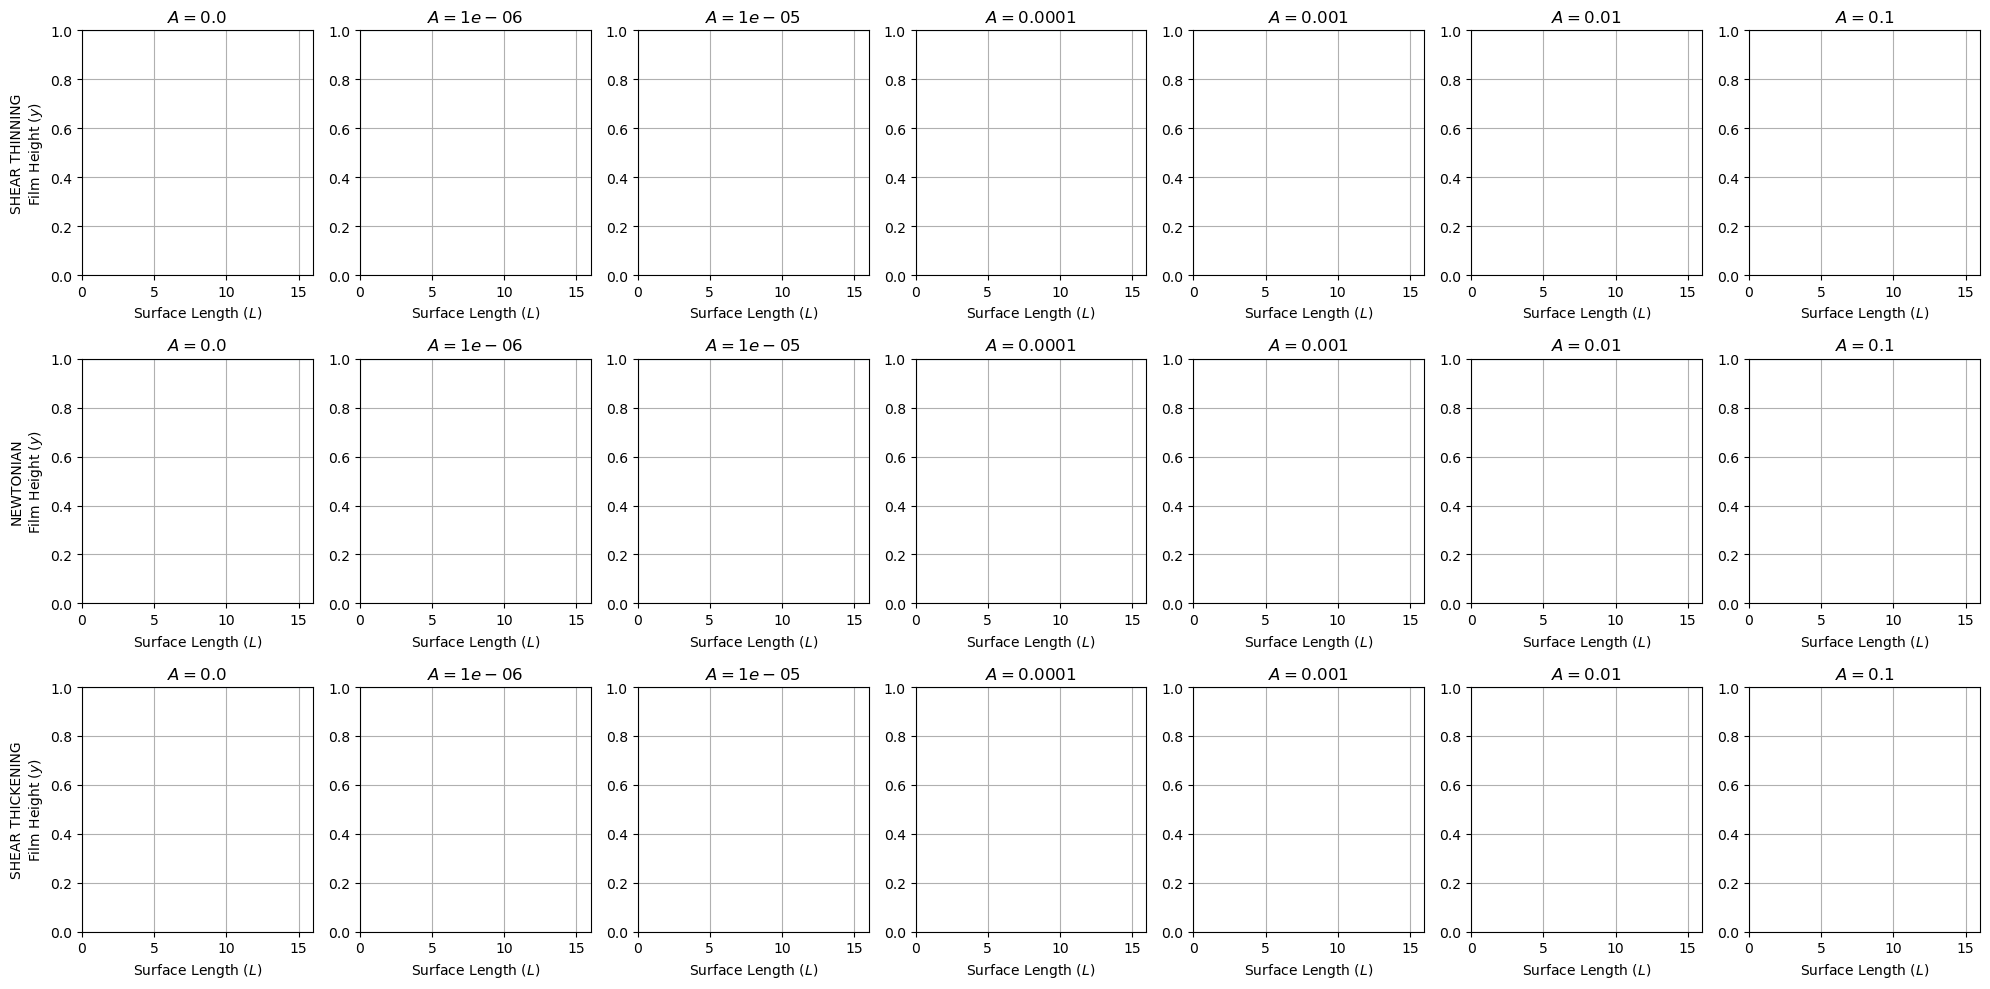

In [7]:
legends = []
grids = []
x_labels = []
titles = []

title_counter = 0
for i in range(len(ns) * len(As)):
    grids.append(True)
    legends.append(False)
    x_labels.append("Surface Length $(L)$")
    titles.append(f"$A={As[title_counter]}$")
    if title_counter == 6:
        title_counter = 0
    else: 
        title_counter += 1

DP_anim = Animation(
    num_rows=3, num_cols=7,
    fig_size=(20, 10), x=GV['x'],
    data=sols, min_timestep=167,
    fig_details = {
        'x-lim': (0, GV['L']),
        'y-lim': (0, GV['h0']),
        'legend': legends,
        'grid': grids,
        'y-label': ["SHEAR THINNING\nFilm Height $(y)$", '', '', '', '', '', '', 
                    "NEWTONIAN\nFilm Height $(y)$", '', '', '', '', '', '', 
                    "SHEAR THICKENING\nFilm Height $(y)$", '', '', '', '', '', ''],
        'x-label': x_labels,
        'title': titles
    }
)
DP_anim.instantiate_animation()
DP_anim.save_animation("animation/DP_anim_varying_A_n")

### Testing

In [142]:
thickening = 1.2
thinning = 0.8
newtonian = 1.0
As = [.0, 0.000001,.00001, .0001, .001, .01, .1]

thickening_list = []
thinning_list = []
newtonian_list = []
for A in As:
    print(f"LOADING | THICKENING | A = {A} |", end='\r')
    args = [PL_DP_make_step, GV['dx'], None, GV['Q'], A, thickening]
    thickening_list.append(solve_ivp(fun=FVM_RHS, y0=h_initial, t_span=t_span, args=(args,), method='BDF', rtol=1e-6, atol=1e-8).y[:, -1])
    
    print(f"LOADING | THINNING   | A = {A} |", end='\r')
    args = [PL_DP_make_step, GV['dx'], None, GV['Q'], A, thinning]
    thinning_list.append(solve_ivp(fun=FVM_RHS, y0=h_initial, t_span=t_span, args=(args,), method='BDF', rtol=1e-6, atol=1e-8).y[:, -1])
    
    print(f"LOADING | NEWTONIAN  | A = {A} |", end='\r')
    args = [PL_DP_make_step, GV['dx'], None, GV['Q'], A, newtonian]
    newtonian_list.append(solve_ivp(fun=FVM_RHS, y0=h_initial, t_span=t_span, args=(args,), method='BDF', rtol=1e-6, atol=1e-8).y[:, -1])

(0.6, 1.0)

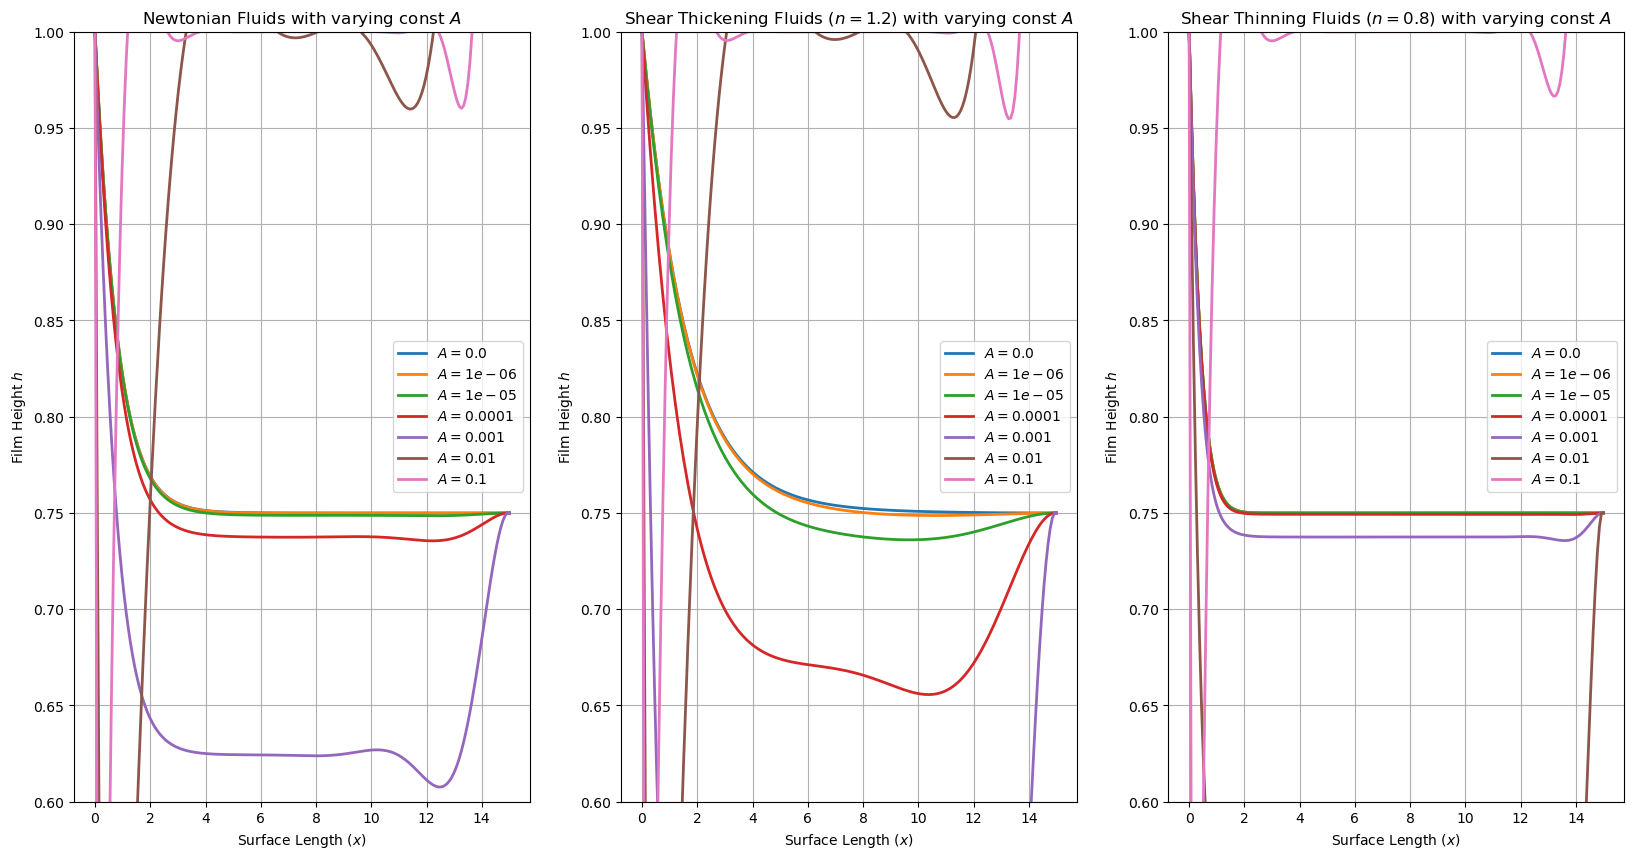

In [146]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

[ax[0].plot(GV['x'], newtonian_list[i], label=f"$A={As[i]}$", linestyle='-', linewidth=2) for i in range(len(As))]
[ax[1].plot(GV['x'], thickening_list[i], label=f"$A={As[i]}$", linestyle='-', linewidth=2) for i in range(len(As))]
[ax[2].plot(GV['x'], thinning_list[i], label=f"$A={As[i]}$", linestyle='-', linewidth=2) for i in range(len(As))]

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)

ax[0].set_xlabel('Surface Length $(x)$')
ax[1].set_xlabel("Surface Length $(x)$")
ax[2].set_xlabel("Surface Length $(x)$")

ax[0].set_ylabel("Film Height $h$")
ax[1].set_ylabel("Film Height $h$")
ax[2].set_ylabel("Film Height $h$")

ax[0].set_title("Newtonian Fluids with varying const $A$")
ax[1].set_title("Shear Thickening Fluids $(n=1.2)$ with varying const $A$")
ax[2].set_title("Shear Thinning Fluids $(n=0.8)$ with varying const $A$")

ax[0].set_ylim([0.6, 1])
ax[1].set_ylim([0.6, 1])
ax[2].set_ylim([0.6, 1])

## Testing for consistency among varying flux

In [176]:
def check_for_success(solution, Q):
    """This function decides whether to claim that the film has been successful, where the status of the ivp solver returns 0, or 
    whether that has been some deformation in the fluid but not significant such that it would affect the fluid, or that
    the fluid fails altogether, where the status returned is -1"""
    # Add success / deformation / fail to stability details
    if solution.status == 0:
        # Compute threshold based on flux
        threshold = Q - 0.02
        # Ask whether the film height moves below the threshold
        if np.min(solution.y[:, -1]) < threshold:
            success = 2
        else: 
            # If it doesn't (False), then it has not deformed too much
            success = 1
    else: 
        # The film has become unstable
        success = 0
    return success

In [187]:
thickening = 1.2
thinning = 0.8
newtonian = 1.0
As = [.0, 0.000001,.00001, .0001, .001, .01, .1]

fluxes_list = np.zeros((len(As), GV['N'], 3, len(GV['Q-list'])))

thickening_stability = np.zeros((len(As), len(GV['Q-list'])))
thinning_stability = np.zeros((len(As), len(GV['Q-list'])))
newtonian_stability = np.zeros((len(As), len(GV['Q-list'])))

for i in range(len(GV['Q-list'])):
    active_Q = GV['Q-list'][i]
    thickening_list = np.zeros((len(As), GV['N']))
    thinning_list = np.zeros((len(As), GV['N']))
    newtonian_list = np.zeros((len(As), GV['N']))
    
    for j in range(len(As)):
        print(f"LOADING | Q = {active_Q} | THICKENING | A = {As[j]} |", end='\r')
        # Define arguments
        args = [PL_DP_make_step, GV['dx'], None, active_Q, As[j], thickening]
        # Compute solve
        sol = solve_ivp(fun=FVM_RHS, y0=h_initial, t_span=t_span, args=(args,), method='BDF', rtol=1e-6, atol=1e-8)
        # Check for success and append to arrays
        thickening_stability[j, i] = check_for_success(sol, active_Q)
        # Append to array for plotting
        thickening_list[j, :] = sol.y[:, -1]
        
        # Do the same for the rest
        print(f"LOADING | Q = {active_Q} | THINNING   | A = {As[j]} |", end='\r')
        args = [PL_DP_make_step, GV['dx'], None, active_Q, As[j], thinning]
        sol = solve_ivp(fun=FVM_RHS, y0=h_initial, t_span=t_span, args=(args,), method='BDF', rtol=1e-6, atol=1e-8)
        thinning_stability[j, i] = check_for_success(sol, active_Q)
        thinning_list[j, :] = sol.y[:, -1]
        
        print(f"LOADING | Q = {active_Q} | NEWTONIAN  | A = {As[j]} |", end='\r')
        args = [PL_DP_make_step, GV['dx'], None, active_Q, As[j], newtonian]
        sol = solve_ivp(fun=FVM_RHS, y0=h_initial, t_span=t_span, args=(args,), method='BDF', rtol=1e-6, atol=1e-8)
        newtonian_stability[j, i] = check_for_success(sol, active_Q)
        newtonian_list[j, :] = sol.y[:, -1]
        
    fluxes_list[:, :, 0, i] = newtonian_list
    fluxes_list[:, :, 1, i] = thinning_list
    fluxes_list[:, :, 2, i] = thickening_list

#### Save these arrays because they take 1hr 30 mins to make

In [193]:
np.save('saved_arrays/varying_Q_A_3ns/results.npy', fluxes_list)
np.save('saved_arrays/varying_Q_A_3ns/newtonian_stability.npy', newtonian_stability)
np.save('saved_arrays/varying_Q_A_3ns/thinning_stability.npy', thinning_stability)
np.save('saved_arrays/varying_Q_A_3ns/thickening_stability.npy', thickening_stability)

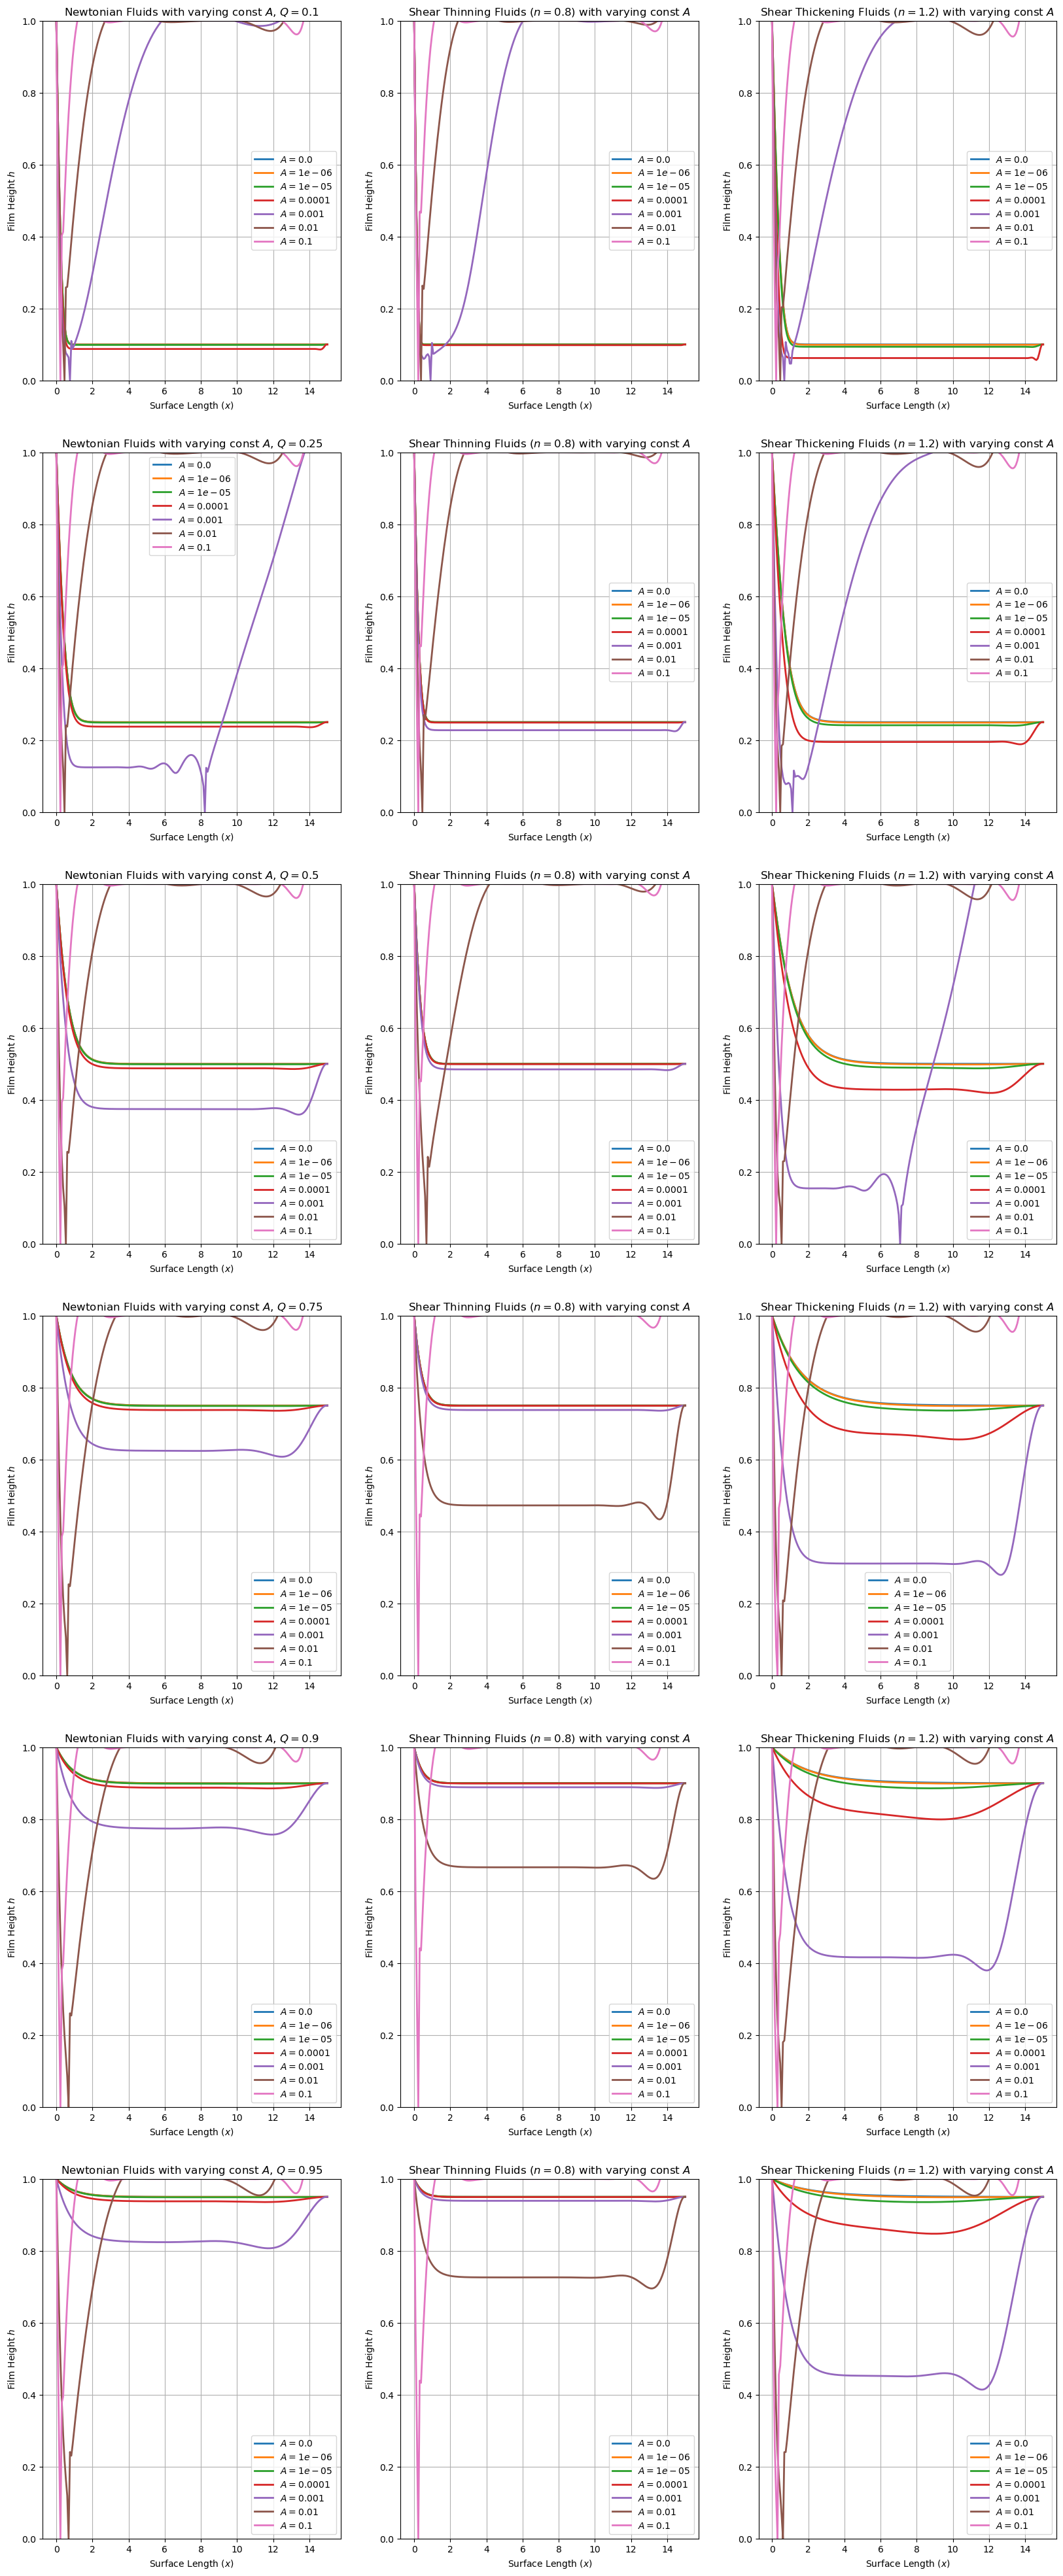

In [191]:
fig, ax = plt.subplots(nrows=len(GV['Q-list']), ncols=3, figsize=(20, 50))

for j in range(len(GV['Q-list'])):

    [ax[j, 0].plot(GV['x'], fluxes_list[i, :, 0, j], label=f"$A={As[i]}$", linestyle='-', linewidth=2) for i in range(len(As))]
    [ax[j, 1].plot(GV['x'], fluxes_list[i, :, 1, j], label=f"$A={As[i]}$", linestyle='-', linewidth=2) for i in range(len(As))]
    [ax[j, 2].plot(GV['x'], fluxes_list[i, :, 2, j], label=f"$A={As[i]}$", linestyle='-', linewidth=2) for i in range(len(As))]
    
    ax[j, 0].legend()
    ax[j, 1].legend()
    ax[j, 2].legend()
    
    ax[j, 0].grid(True)
    ax[j, 1].grid(True)
    ax[j, 2].grid(True)
    
    ax[j, 0].set_xlabel('Surface Length $(x)$')
    ax[j, 1].set_xlabel("Surface Length $(x)$")
    ax[j, 2].set_xlabel("Surface Length $(x)$")
    
    ax[j, 0].set_ylabel("Film Height $h$")
    ax[j, 1].set_ylabel("Film Height $h$")
    ax[j, 2].set_ylabel("Film Height $h$")
    
    ax[j, 0].set_title(f"Newtonian Fluids with varying const $A$, $Q={GV['Q-list'][j]}$")
    ax[j, 1].set_title("Shear Thinning Fluids $(n=0.8)$ with varying const $A$")
    ax[j, 2].set_title("Shear Thickening Fluids $(n=1.2)$ with varying const $A$")

    ax[j, 0].set_ylim(0, 1)
    ax[j, 1].set_ylim(0, 1)
    ax[j, 2].set_ylim(0, 1)

### Now we know shear thinning appears better, what are the limits of this?

In [ ]:
As = [.0, 0.000001,.00001, .0001, .001, .01, .1]
ns = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
fluxes_list_ns = np.zeros((len(As), GV['N'], len(GV['Q-list']), len(ns)))
thinning_stabilities = np.zeros((len(As), len(GV['Q-list']), len(ns)))

for i in range(len(ns)):
    active_n = ns[i]
    for j in range(len(GV['Q-list'])):
        active_Q = GV['Q-list'][j]
        for k in range(len(As)):
            active_A = As[k]
            print(f"LOADING | n = {active_n} | Q = {active_Q} | A = {active_A}", end='\r')
            # Define arguments
            args = [PL_DP_make_step, GV['dx'], None, active_Q, active_A, active_n]
            # Compute solve
            sol = solve_ivp(fun=FVM_RHS, y0=h_initial, t_span=t_span, args=(args,), method='BDF', rtol=1e-6, atol=1e-8)
            # Check for success and append to arrays
            thinning_stabilities[k, j, i] = check_for_success(sol, active_Q)
            # Append to array for plotting
            fluxes_list_ns[k, :, j, i] = sol.y[:, -1]

In [ ]:
# Save files to folder
np.save('saved_arrays/varying_shear_thinning_Q_A/results.npy', fluxes_list_ns)
np.save('saved_arrays/varying_shear_thinning_Q_A/thinning_stability.npy', thinning_stabilities)

In [ ]:
fig, ax = plt.subplots(nrows=len(ns), ncols=4, figsize=(25, 60))
plt.subplots_adjust(wspace=0.0)
for j in range(len(ns)):

    [ax[j, 0].plot(GV['x'], fluxes_list_ns[i, :, 0, j], label=f"$A={As[i]}$", linestyle='-', linewidth=2) for i in range(len(As))]
    [ax[j, 1].plot(GV['x'], fluxes_list_ns[i, :, 1, j], label=f"$A={As[i]}$", linestyle='-', linewidth=2) for i in range(len(As))]
    [ax[j, 2].plot(GV['x'], fluxes_list_ns[i, :, 3, j], label=f"$A={As[i]}$", linestyle='-', linewidth=2) for i in range(len(As))]
    [ax[j, 3].plot(GV['x'], fluxes_list_ns[i, :, 5, j], label=f"$A={As[i]}$", linestyle='-', linewidth=2) for i in range(len(As))]

    
    ax[j, 0].legend()
    ax[j, 1].legend()
    ax[j, 2].legend()
    ax[j, 3].legend()
    
    ax[j, 0].grid(True)
    ax[j, 1].grid(True)
    ax[j, 2].grid(True)
    ax[j, 3].grid(True)
    
    ax[j, 0].set_xlabel('Surface Length $(x)$')
    ax[j, 1].set_xlabel("Surface Length $(x)$")
    ax[j, 2].set_xlabel("Surface Length $(x)$")
    ax[j, 3].set_xlabel("Surface Length $(x)$")
    
    ax[j, 0].set_ylabel(f"Film Height $h$, $(n={ns[j]})$")
    
    ax[j, 0].set_title(f"Fluxes for Q={GV['Q-list'][0]}")
    ax[j, 1].set_title(f"Fluxes for Q={GV['Q-list'][1]}")
    ax[j, 2].set_title(f"Fluxes for Q={GV['Q-list'][3]}")
    ax[j, 3].set_title(f"Fluxes for Q={GV['Q-list'][5]}")

    ax[j, 0].set_ylim(0, 1)
    ax[j, 1].set_ylim(0, 1)
    ax[j, 2].set_ylim(0, 1)
    ax[j, 3].set_ylim(0, 1)

# fig.savefig("saved_arrays/varying_shear_thinning_Q_A/varying_n.png")

In [7]:
thinning_stabilities = np.load('saved_arrays/varying_shear_thinning_Q_A/thinning_stability.npy')
[print(thinning_stabilities[:, :, i]) for i in range(thinning_stabilities.shape[2])]

[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1.]]
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1.]]
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1.]]
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1.]
 [0. 0. 2. 1. 1. 1.]]
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 2. 2.]]
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [0. 0. 2. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]]
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [0. 0.

[None, None, None, None, None, None, None, None, None, None]

### Testing if varying length L has any affect on the instability (Suggested by Ferran 21st July)

This will be a simpler test and shouldn't take too long to run. Just testing one n, $(1.0)$, with one flux that is guaranteed to cause instability $(Q=0.5)$ at a given disjoint pressure $(A=0.001)$. We will then vary L to test if the boundaries change when L is increased/decreased. <br> Hypothesis: The length scale L is ONLY used when computing $\Delta x$ and when plotting the film. Therefore, the only thing that L is used for in the computations is $\Delta x$, so if we keep dx the same, the film behaviour should remain consistent. So here we compute a new dx for every length scale L

In [8]:
Q = 0.75
A = 0.0
n = 1.0
h_initial = np.ones(GV['N']) * GV['h0']

fluxes_varying_L = np.zeros((len(GV['L-list']), GV['N']))
animation_data = []

for i, L in enumerate(GV['L-list']):
    min_t = GV['t-span'][f"{L}"]
    t_span = (0, min_t)

    new_dx = L/GV['N']
    
    print(f"LOADING | L = {L} | dx = {np.round(new_dx, 4)} | t = {min_t}", end='\r')
    
    # Define arguments
    args = [PL_DP_make_step, new_dx, None, Q, A, n]
    # Compute solve
    sol = solve_ivp(fun=FVM_RHS, y0=h_initial, t_span=t_span, args=(args,), method='BDF', rtol=1e-6, atol=1e-8)
    fluxes_varying_L[i, :] = sol.y[:, -1]
    animation_data.append(sol.y)

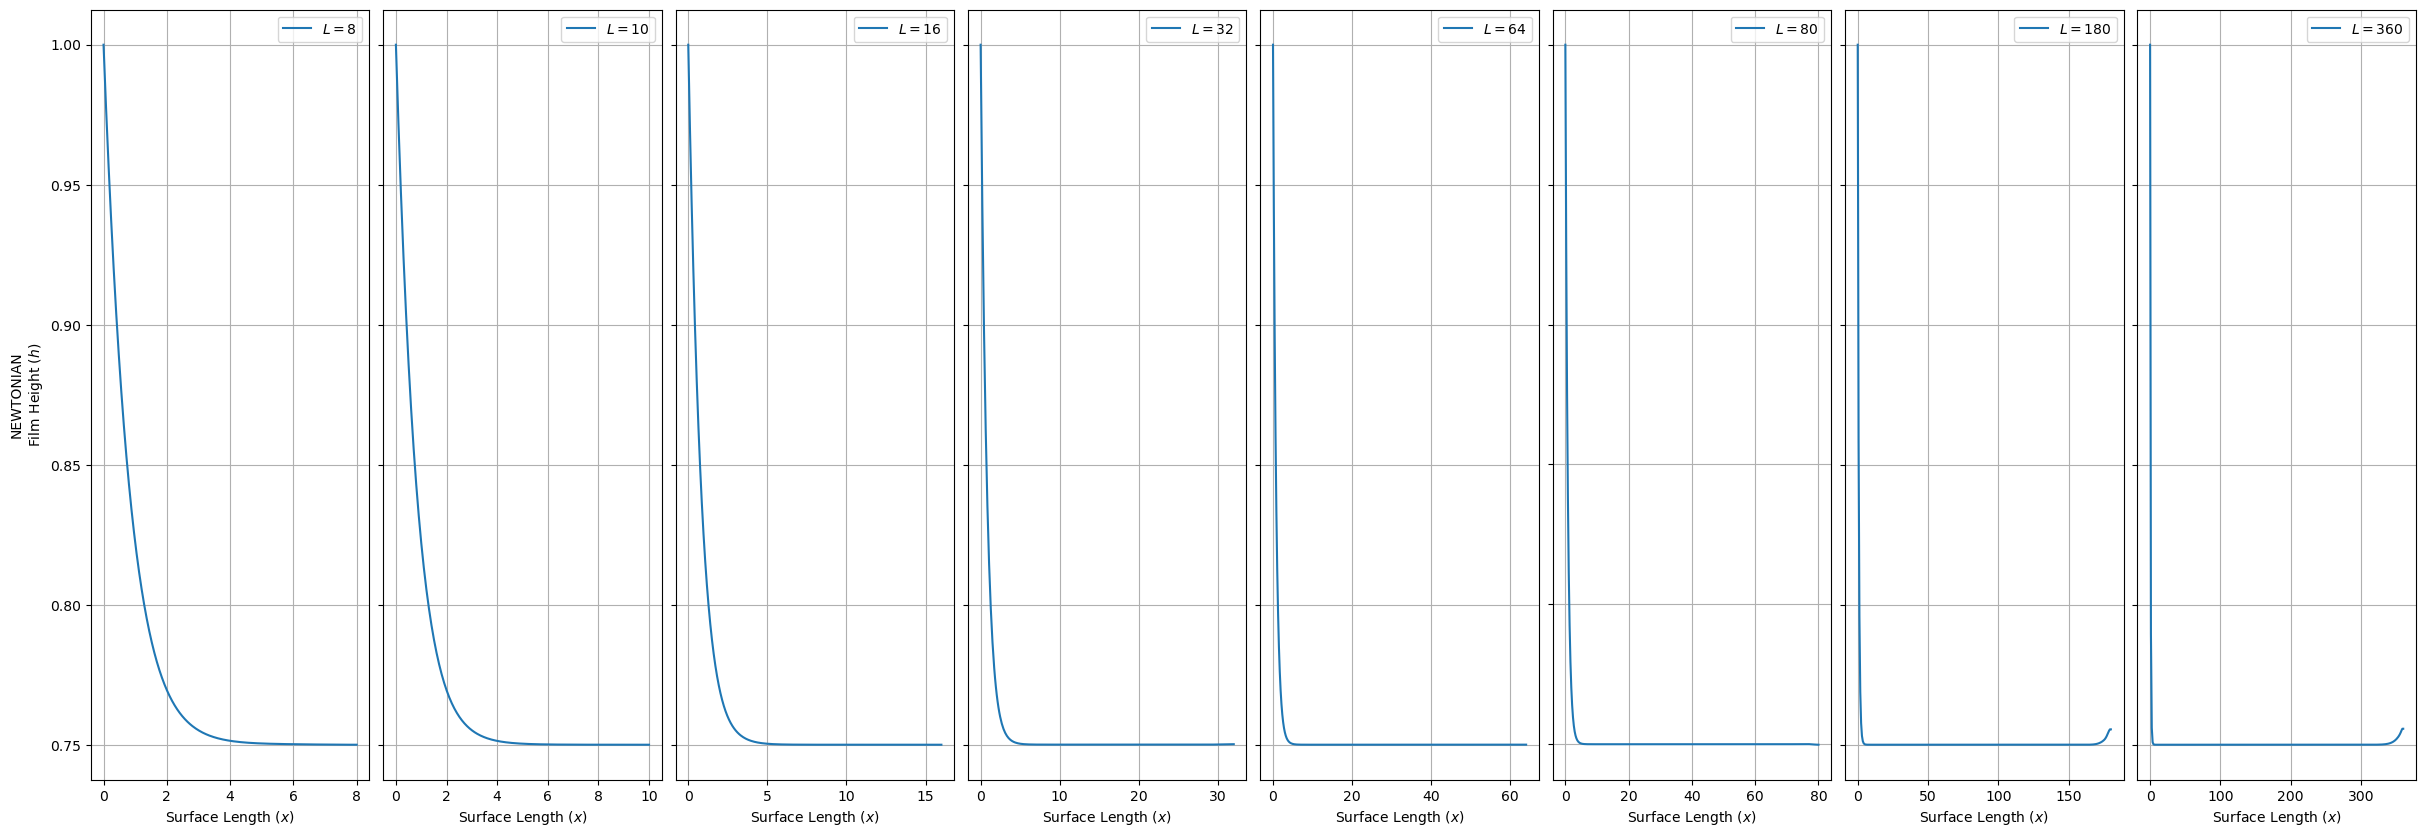

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=len(GV['L-list']), figsize=(30, 10))
plt.subplots_adjust(wspace=0.05, hspace=0.0)

for i in range(len(GV['L-list'])):
    xL = np.linspace(0, GV['L-list'][i], GV['N'])
    ax[i].plot(xL, fluxes_varying_L[i, :], label=f"$L={GV['L-list'][i]}$")
    ax[i].grid(True)
    ax[i].legend()
    
    if i == 0:
        ax[i].set_ylabel("NEWTONIAN\nFilm Height $(h)$")
    else:
        ax[i].set_yticklabels([])
    
    ax[i].set_xlabel("Surface Length $(x)$")

Conclusion, given enough time, the length scale L does not have an effect on the behaviour of the film given enough time t, this prompts a calculation for the minimum t to find the steady state solution from startup flow for every L which one can find in the cluster_running/finding_steady_state directory.

## Generating animations

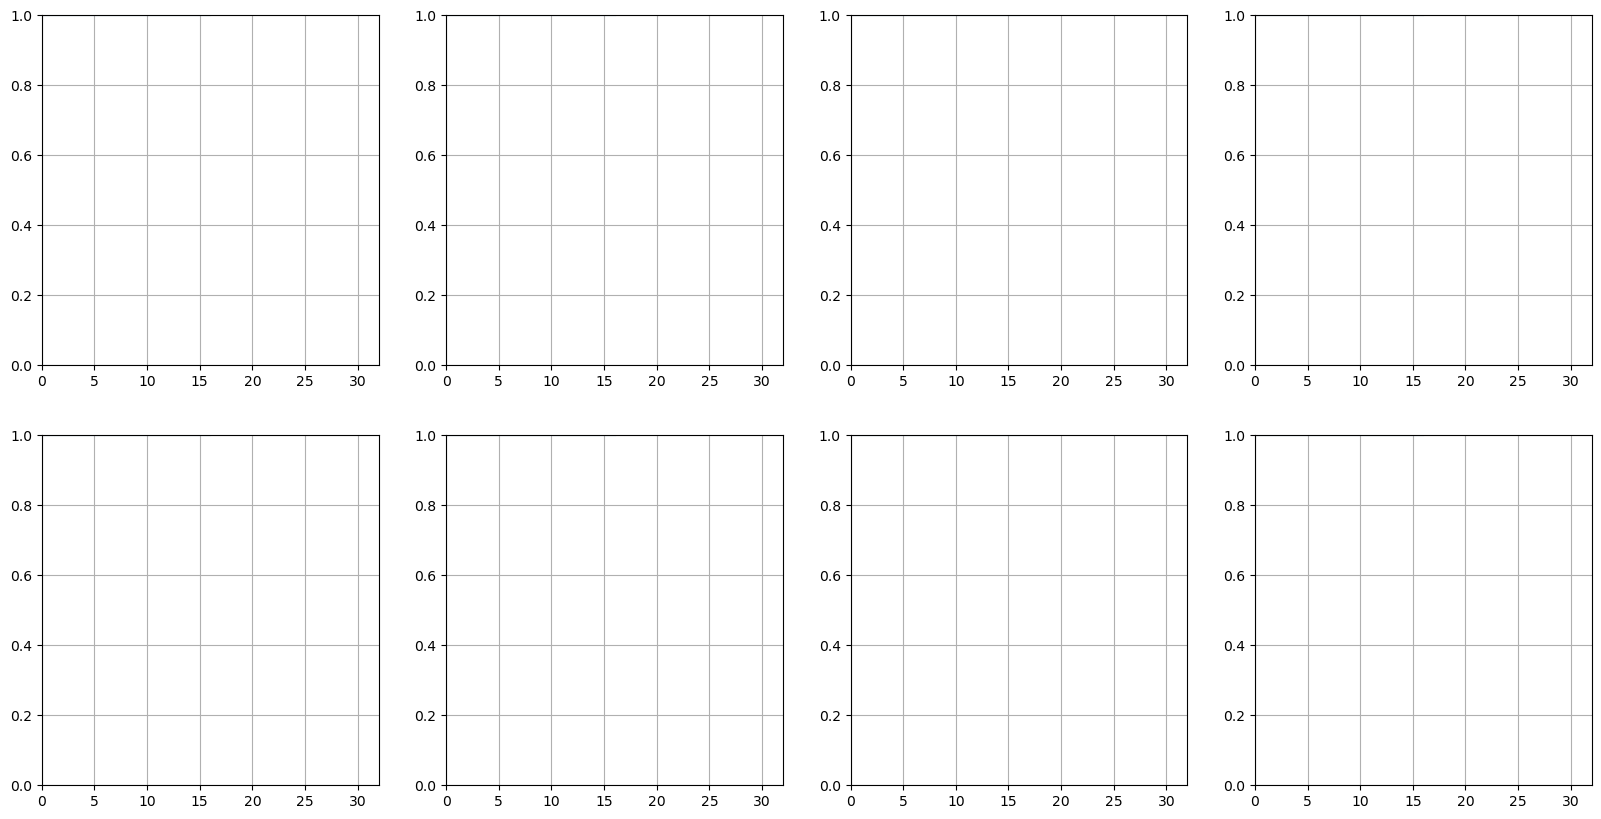

In [12]:
new_data = []
for i in range(8):
    active_data = animation_data[i]
    new_data.append(active_data[None, :, :])

L_anim = Animation(
    num_rows=2, num_cols=4,
    fig_size=(20, 10), x=GV['x'],
    data=new_data, num_frames=139,
    fig_details={'x-lim': (0, 32), 'y-lim': (0, GV['h0']), 'legend': [False, False, False, False, False, False, False, False]}
)

L_anim.instantiate_animation()
L_anim.save_animation("L_anim")

## Testing Edge Cases

### Vibration in Extrusion

Here, we vary $h_0$ over time to simulate various scenarios. To do this, we make the solver update $h_0$ from a function of our choosing which takes the timestep as an input, such that we can manipulate the behaviour of $h_0$.
To simulate vibration in the extrusion, we can choose $h_0$ to be a high frequency sinusoid curve to observe how the film behaves.
We must define a new ```FVM_RHS``` function that will update $h_0$ via a function of our choosing. We also need to define a new ```PL_DP_make_step``` function because the args tuple will be different.

In [99]:
def FVM_RHS_h_0(t:float, h:np.ndarray, args:tuple) -> np.ndarray:
    """
    RHS of equation, made for scipy's solve_ivp function that takes care of this stiff fourth order PDE. We include the new h_0 function
    in the args tuple.
    """
    
    N = GV['N']
    
    make_step, h_0_func, h_0_func_args, dx, Q, _, n = args 
    
    h = h.copy()
    dhdt = np.zeros_like(h)

    # i = 0
    Amp, f, phi = h_0_func_args
    h[0] = h_0_func(t, Amp, f, phi) + GV['h0']
    h_tracker.append(h[0])
    
    # i = 1
    q_plus, q_minus = make_step(h=h, i=1, args=args)
    dhdt[1] = - (q_plus - Q) / dx

    # i = N - 2
    q_plus, q_minus = make_step(h=h, i=N-2, args=args)
    dhdt[N-2] = - (h[N-2] - q_minus) / dx

    # i = N - 1
    h[N-1] = h[N-2]
    dhdt[N-1] = dhdt[N-2]

    for i in range(2, N-2):
        q_plus, q_minus = make_step(h=h, i=i, args=args)
        dhdt[i] = -(q_plus - q_minus) / dx

    return dhdt

In [100]:
def h_0_sine(t:float, Amp:float, f:float, phi:float) -> float:
    """
    :param t: Time (seconds) 
    :param A: Amplitude
    :param f: Frequency (Hz)
    :param phi: (Phase shift)
    """
    return Amp * np.sin(2 * np.pi * f * t + phi)

In [101]:
def PL_DP_make_step_h_0(h, i, args):
    """
    (Try, except)'s are for the BCs, as q_minus won't be computable for BCs at the start and q_plus won't be computable
    for BCs at the end.
    The bool 'print_except' is for making sure anything inside the for loop is not displaying a 0.
    """
    
    _, _, _, dx, Q, A, n = args 

    DX = 1/dx**3
    epsilon = 0

    try:
        disjoining_pressure_term = -A/(6*np.pi*h[i]**3)
        non_linear_h = (0.5 * (h[i] + h[i+1]))**((2*n + 1)/n) + epsilon
        third_order = abs(-h[i-1] + 3*h[i] - 3*h[i+1] + h[i+2] + epsilon - disjoining_pressure_term) ** (1 / n)
        third_order_sign = np.sign(-h[i-1] + 3*h[i] - 3*h[i+1] + h[i+2] - disjoining_pressure_term)
        advection_term = h[i]

        q_plus = DX  * non_linear_h * third_order_sign * third_order + advection_term

    except IndexError:
        q_plus = 0

    try:
        disjoining_pressure_term = -A/(6*np.pi*h[i-1]**3)
        non_linear_h = (0.5 * (h[i] + h[i-1])) ** ((2*n+1)/n) + epsilon
        third_order = abs(-h[i-2] + 3*h[i-1] - 3*h[i] + h[i+1] + epsilon - disjoining_pressure_term) ** (1 / n)
        third_order_sign = np.sign(-h[i-2] + 3*h[i-1] - 3*h[i] + h[i+1] - disjoining_pressure_term)
        advection_term = h[i-1]

        q_minus = DX * non_linear_h * third_order_sign * third_order + advection_term

    except IndexError:
        q_minus = 0

    return q_plus, q_minus

### Testing

In [118]:
n = 1.0
DP = 0.001
h_initial = np.ones(GV['N']) * GV['h0']
t_span = GV['t-span']

Amp = 0.1
f = 10
phi = 0
h_0_args = (Amp, f, phi)
args = [PL_DP_make_step_h_0, h_0_sine, h_0_args, GV['dx'], GV['Q'], DP, n]
h_tracker = []

sol = solve_ivp(fun=FVM_RHS_h_0, y0=h_initial, t_span=t_span, args=(args,), method='BDF', rtol=1e-6, atol=1e-8)

print(sol.status)
print(sol.success)
print(sol.message)

0
True
The solver successfully reached the end of the integration interval.


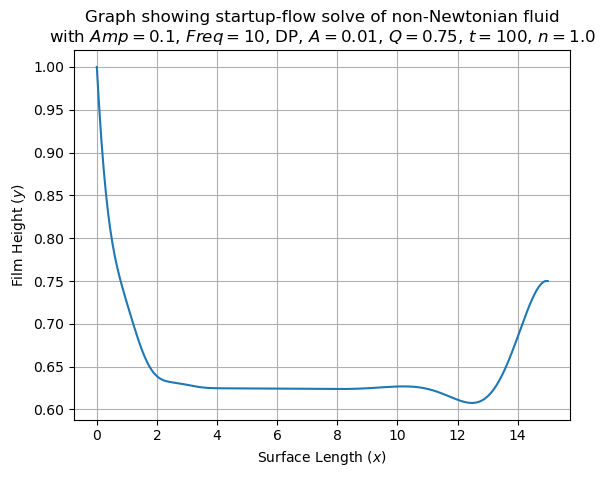

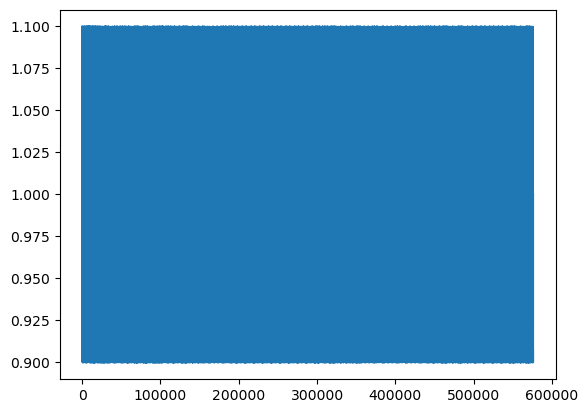

In [120]:
plt.plot(GV['x'], sol.y[:, -1])
plt.title(f"Graph showing startup-flow solve of non-Newtonian fluid\nwith $Amp=0.1$, $Freq=10$, DP, $A=0.01$, $Q={GV['Q']}$, $t={GV['t-span'][1]}$, $n={n}$")
plt.grid(True)
plt.xlabel('Surface Length $(x)$')
plt.ylabel('Film Height $(y)$')
plt.show()

plt.plot(h_tracker)

## ERROR GRAPHS
To ensure the model's validity, each model will be compared with the steady state Newtonian flow and an error plot will be made.

In [32]:
# Newtonian steady state solve
steady_state_newt = steady_newt_solver(q=GV['Q'], L=15, linear=False).y[0]

# Newtonian startup flow solve
args = [newt_make_step, GV['dx'], 3, GV['Q'], None]
h_initial = np.ones(GV['N']) * GV['h0']
t_span = GV['t-span']
startup_flow_newt = solve_ivp(fun=FVM_RHS, args=(args,), y0=h_initial, t_span=t_span, method='BDF', rtol=1e-6, atol=1e-8).y[:, -1]

# Power-law startup flow solve
args = [PL_make_step, GV['dx'], None, GV['Q'], 1]
startup_flow_PL = solve_ivp(fun=FVM_RHS, y0=h_initial, t_span=t_span, args=(args,), method='BDF', rtol=1e-6, atol=1e-8).y[:, -1]

(0.001, 0.00105)

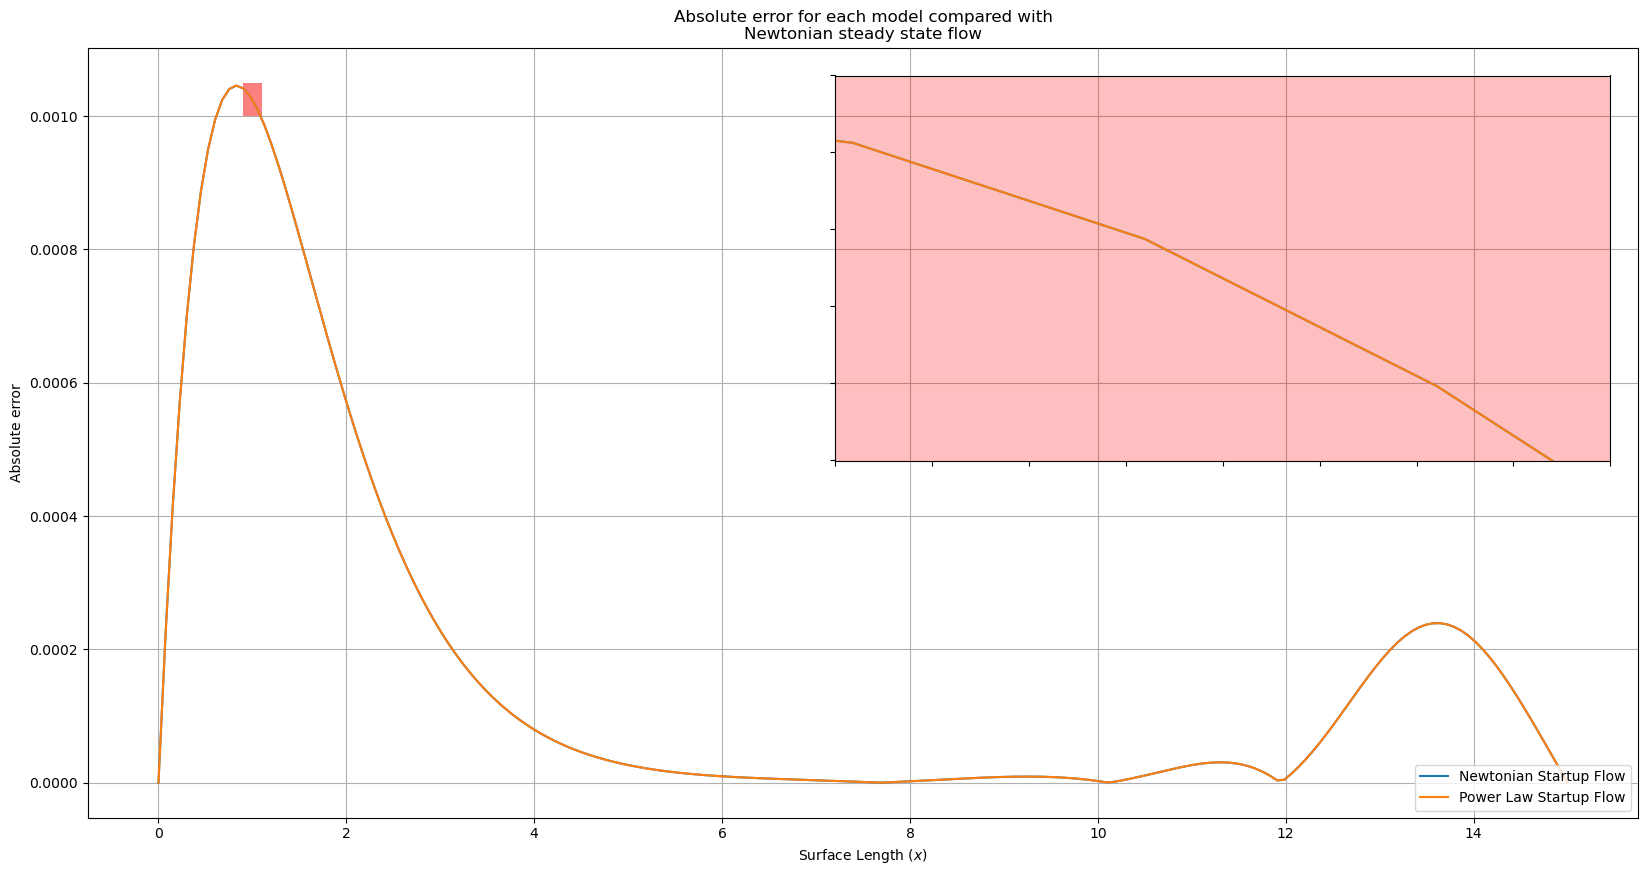

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

ax.plot(GV['x'], abs(steady_state_newt - startup_flow_newt), label="Newtonian Startup Flow")
ax.plot(GV['x'], abs(steady_state_newt - startup_flow_PL), label="Power Law Startup Flow")

slice_x = (0.9, 1.1)
slice_y = (0.0010, 0.00105)

ax.legend(loc='lower right')
ax.grid(True)
ax.set_title("Absolute error for each model compared with\nNewtonian steady state flow")
ax.set_ylabel("Absolute error")
ax.set_xlabel("Surface Length $(x)$")
ax.add_patch(plt.Rectangle(xy=(slice_x[0], slice_y[0]), width=(slice_x[1]-slice_x[0]), height=(slice_y[1] - slice_y[0]), ls='--', fc='#fa000080'))

inset_ax = inset_axes(ax, width='50%', height='50%', loc='upper right', borderpad=2, axes_kwargs={'facecolor': '#fa000040'})
inset_ax.plot(GV['x'], abs(steady_state_newt - startup_flow_newt))
inset_ax.plot(GV['x'], abs(steady_state_newt - startup_flow_PL))
inset_ax.set_xticklabels([])
inset_ax.set_yticklabels([])
inset_ax.set_xlim(slice_x[0], slice_x[1])
inset_ax.set_ylim(slice_y[0], slice_y[1])